In [124]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import itertools
from scipy.stats import chi2_contingency 
from scipy.stats.mstats import winsorize
from scipy.sparse import csr_matrix

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition  import TruncatedSVD
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.utils import resample
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split, cross_val_score
from sklearn.feature_extraction.text import  HashingVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC 
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import xgboost
from xgboost import XGBClassifier

#from decision import plot_decision_regions
#from pipelines import extra_features

In [210]:
train=pd.read_csv('../Datasets/Train.csv')
test=pd.read_csv('../datasets/test.csv')

In [211]:
print(train.shape, test.shape)

(18506, 21) (6169, 20)


In [212]:
train.head(2)

,Tour_ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,...,package_accomodation,package_food,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,first_trip_tz,cost_category
0,tour_id1hffseyw,ITALY,45-64,With Children,0.0,2.0,Visiting Friends and Relatives,Beach Tourism,"Friends, relatives",Package Tour,...,Yes,Yes,Yes,No,No,No,0,7,Yes,High Cost
1,tour_idnacd7zag,UNITED KINGDOM,25-44,With Spouse,1.0,1.0,Leisure and Holidays,Wildlife Tourism,"Travel agent, tour operator",Package Tour,...,Yes,Yes,Yes,No,No,No,0,7,Yes,High Cost


In [213]:
test.loc[:, "cost_category"] = -1
test.tail(2)

,Tour_ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,...,package_accomodation,package_food,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,first_trip_tz,cost_category
6167,tour_idx80vbw5a,CANADA,18-24,Alone,1.0,0.0,Visiting Friends and Relatives,Wildlife Tourism,"Friends, relatives",Independent,...,No,No,No,No,No,No,21,0,No,-1
6168,tour_id8fkkwytb,KENYA,45-64,NaN,0.0,1.0,Meetings and Conference,Wildlife Tourism,"Friends, relatives",Independent,...,No,No,No,No,No,No,4,0,Yes,-1


In [214]:
train['country'].replace({'UAE': "UNITED ARAB EMIRATES",
                          'SWIZERLAND': 'SWITZERLAND',
                          'MALT': 'MALTA',
                          'COSTARICA': 'COSTA RICA',
                          'COMORO': 'COMOROS',
                          'SAUD ARABIA': 'SAUDI ARABIA',
                          'PHILIPINES': 'PHILIPPINES',
                          'ECUADO': 'ECUADOR',
                          'UKRAIN':'UKRAINE',
                          'SOMALI':'SOMALIA',
                          'TRINIDAD TOBACCO': 'TRINIDAD AND TOBAGO',
                          'MONECASQUE': 'MOZAMBIQUE',
                          'DJIBOUT': 'DJIBOUTI',
                          'BURGARIA': 'BULGARIA',
                          'United Kingdom of Great Britain and Northern Ireland': 'UNITED KINGDOM'
                                }, inplace=True)

train['country'].unique()

array(['ITALY', 'UNITED KINGDOM', 'UNITED STATES OF AMERICA', 'RWANDA',
       'FRANCE', 'SWITZERLAND', 'NIGERIA', 'AUSTRALIA', 'SPAIN',
       'DENMARK', 'BELGIUM', 'ZAMBIA', 'NETHERLANDS', 'CANADA', 'INDIA',
       'NORWAY', 'ZIMBABWE', 'MORROCO', 'CHINA', 'GERMANY',
       'SOUTH AFRICA', 'JAPAN', 'UNITED ARAB EMIRATES', 'RUSSIA', 'KENYA',
       'GREECE', 'POLAND', 'AUSTRIA', 'MALAYSIA', 'CZECH REPUBLIC',
       'KOREA', 'DRC', 'CYPRUS', 'KUWAIT', 'BRAZIL', 'CHILE', 'BULGARIA',
       'ISRAEL', 'NEW ZEALAND', 'UGANDA', 'IRELAND', 'SWEDEN', 'QATAR',
       'CONGO', 'BURUNDI', 'FINLAND', 'GHANA', 'OMAN', 'LEBANON',
       'LUXEMBOURG', 'IVORY COAST', 'NAMIBIA', 'ROMANIA', 'THAILAND',
       'SUDAN', 'SINGAPORE', 'PORTUGAL', 'MALAWI', 'MALTA', 'EGYPT',
       'PAKISTAN', 'TANZANIA', 'ARGENTINA', 'SRI LANKA', 'BOTSWANA',
       'VIETNAM', 'BERMUDA', 'TAIWAN', 'SENEGAL', 'AFGHANISTAN',
       'COLOMBIA', 'JAMAICA', 'BAHRAIN', 'COSTA RICA', 'COMOROS',
       'URUGUAY', 'SAUDI ARABIA', 'E

In [215]:
#Checking if there's conflicting Tourist Ids in both datasets.
train['Tour_ID'].isin(test['Tour_ID']).sum()

0

In [216]:
df = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)
df['main_activity'].replace({"Widlife Tourism": "Wildlife Tourism"}, inplace=True)
df['age_group'].replace({'<18':'1-17', '65+':'65-84'}, inplace=True)
#df.set_index('Tour_ID', inplace=True)
df.drop_duplicates(keep='first', inplace=True)

In [217]:
for col in df.select_dtypes(np.number):
    if col != ('total_male'):
        quartiles = np.percentile(df[col].fillna(df[col].median()), [25, 50, 75])
        mu = quartiles[1]
        sig = 0.74 * (quartiles[2] - quartiles[0])
        df.loc[:, col] = df.query(f'({col}.values > @mu - 3 * @sig) & ({col}.values < @mu + 3 * @sig)')
    else:
        df.loc[:, col] = df.query(f'({col}.values > @mu - 5 * @sig) & ({col}.values < @mu + 5 * @sig)')  

    df.loc[:, col] = df[col].fillna(df[col].median())

In [218]:
df.country.values

array(['ITALY', 'UNITED KINGDOM', 'UNITED STATES OF AMERICA', ...,
       'CANADA', 'CANADA', 'KENYA'], dtype=object)

In [223]:
countries = pd.read_csv("../Datasets/all.csv")
countries.drop(columns=['alpha-2', 'alpha-3', 'country-code', 'iso_3166-2', 'intermediate-region', 'region-code',
                        'sub-region-code', 'intermediate-region-code'], axis=1, inplace=True)
countries.rename({'name':'country'}, axis=1, inplace=True)
countries.country = countries['country'].str.title()
countries.head()

,country,region,sub-region
0,Afghanistan,Asia,Southern Asia
1,Åland Islands,Europe,Northern Europe
2,Albania,Europe,Southern Europe
3,Algeria,Africa,Northern Africa
4,American Samoa,Oceania,Polynesia


In [224]:
df['country'] = df['country'].str.title()

In [225]:
df.country.values

array(['Italy', 'United Kingdom', 'United States Of America', ...,
       'Canada', 'Canada', 'Kenya'], dtype=object)

In [226]:
for country in countries:
    if countries['country'].isin(df['country']).all():
        print(country)

In [227]:
countries['country'].isin(df['country']).sum()

126

In [228]:
concat = df.merge(countries, how='left')
concat.head()

,Tour_ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,...,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,first_trip_tz,cost_category,region,sub-region
0,tour_id1hffseyw,Italy,45-64,With Children,0.0,2.0,Visiting Friends and Relatives,Beach Tourism,"Friends, relatives",Package Tour,...,Yes,No,No,No,0.0,7.0,Yes,High Cost,Europe,Southern Europe
1,tour_idnacd7zag,United Kingdom,25-44,With Spouse,1.0,1.0,Leisure and Holidays,Wildlife Tourism,"Travel agent, tour operator",Package Tour,...,Yes,No,No,No,0.0,7.0,Yes,High Cost,Europe,Northern Europe
2,tour_id62vz7e71,United States Of America,65-84,With Spouse,1.0,1.0,Leisure and Holidays,Wildlife Tourism,"Travel agent, tour operator",Package Tour,...,Yes,Yes,Yes,No,6.0,6.0,Yes,Higher Cost,Americas,Northern America
3,tour_idrc76tzix,Rwanda,25-44,With Spouse and Children,3.0,1.0,Leisure and Holidays,Beach Tourism,"Radio, TV, Web",Independent,...,No,No,No,No,3.0,0.0,No,Lower Cost,Africa,Sub-Saharan Africa
4,tour_idn723m0n9,United States Of America,45-64,Alone,0.0,1.0,Leisure and Holidays,Wildlife Tourism,"Travel agent, tour operator",Package Tour,...,Yes,No,Yes,Yes,7.0,0.0,Yes,Higher Cost,Americas,Northern America


In [229]:
concat.tail()

,Tour_ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,...,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,first_trip_tz,cost_category,region,sub-region
24670,tour_id2deyfjhq,Zimbabwe,25-44,Alone,0.0,1.0,Business,Wildlife Tourism,"Friends, relatives",Independent,...,No,No,No,No,2.0,0.0,No,-1,Africa,Sub-Saharan Africa
24671,tour_idlenv2rio,Drc,25-44,Alone,0.0,1.0,Visiting Friends and Relatives,Hunting Tourism,"Friends, relatives",Independent,...,No,No,No,No,6.0,0.0,Yes,-1,NaN,NaN
24672,tour_id7wwqrs0p,Canada,25-44,Alone,0.0,1.0,Leisure and Holidays,Beach Tourism,"Friends, relatives",Package Tour,...,Yes,No,No,No,5.0,0.0,No,-1,Americas,Northern America
24673,tour_idx80vbw5a,Canada,18-24,Alone,1.0,0.0,Visiting Friends and Relatives,Wildlife Tourism,"Friends, relatives",Independent,...,No,No,No,No,21.0,0.0,No,-1,Americas,Northern America
24674,tour_id8fkkwytb,Kenya,45-64,NaN,0.0,1.0,Meetings and Conference,Wildlife Tourism,"Friends, relatives",Independent,...,No,No,No,No,4.0,0.0,Yes,-1,Africa,Sub-Saharan Africa


In [230]:
concat.shape, df.shape, countries.shape

((24675, 23), (24675, 21), (249, 3))

In [231]:
concat.region.value_counts()

Europe      11004
Africa       5455
Americas     4752
Asia         1917
Oceania      1048
Name: region, dtype: int64

In [232]:
concat['sub-region'].value_counts()

Sub-Saharan Africa                 5400
Northern America                   4567
Western Europe                     3982
Northern Europe                    3843
Southern Europe                    2933
Australia and New Zealand          1044
Southern Asia                       598
Eastern Asia                        574
Western Asia                        565
Eastern Europe                      246
Latin America and the Caribbean     185
South-eastern Asia                  179
Northern Africa                      55
Melanesia                             4
Central Asia                          1
Name: sub-region, dtype: int64

In [233]:
df = concat

In [56]:
for age in df['age_group'].unique():
    freq = df.groupby(['age_group'])['Tour_ID'].count()
    l = np.array([0.5, 17.5, 24.5, 44.5, 64.5])
    u = np.array([17.5, 24.5, 44.5, 64.5, 84.5])
    c_interval = (u - l)
    fd = dict(freq / c_interval)

df['age_group'] =  df['age_group'].map(fd) 

In [57]:
mean = np.sum(df['age_group']) / len(df['age_group'])
df['age_group'] = mean - df['age_group'].values

In [154]:
df.columns

Index(['Tour_ID', 'country', 'age_group', 'travel_with', 'total_female',
       'total_male', 'purpose', 'main_activity', 'info_source',
       'tour_arrangement', 'package_transport_int', 'package_accomodation',
       'package_food', 'package_transport_tz', 'package_sightseeing',
       'package_guided_tour', 'package_insurance', 'night_mainland',
       'night_zanzibar', 'first_trip_tz', 'cost_category', 'region',
       'sub-region'],
      dtype='object')

In [59]:
df.eval('total_nights = night_mainland + night_zanzibar', inplace=True) 

#Length of stay on weekly basis
df['tour_duration'] = df['total_nights'].copy()
df['tour_duration'] /= 7

df.eval('total_people = total_male + total_female', inplace=True)
df['av_tmale_per_tp'] = df.groupby('total_people')['total_male'].transform('mean')
df['av_tfemale_per_tp'] = df.groupby(['total_people'])['total_female'].transform('mean')
df['av_tp_per_purpose'] = df.groupby(['purpose'])['total_people'].transform('mean')
df['info_source & purpose'] = df.groupby(['info_source', 'purpose'])['Tour_ID'].transform('count')
df['mean_age_density_per_country'] = df.groupby('country')['age_group'].transform('mean')
df['mean_age_density_per_main_activity'] = df.groupby('main_activity')['age_group'].transform('mean')
df['mean_age_density_per_info'] = df.groupby(['info_source'])['age_group'].transform('mean')

gender = []
for g in df[['total_people']]:
    result = df['total_male'].values - df['total_female'].values
    for i in result:
        if i > 0:
            gender.append('Male')
        elif i < 0:
            gender.append('Female')
        else:
            gender.append('Equal')
            
df['dominant_gender'] = gender
df['av_stay_per_gender'] = df.groupby(['dominant_gender'])['tour_duration'].transform('mean')

In [60]:
df.groupby(['dominant_gender'])['tour_duration'].transform('mean')#.plot(kind='hist')

0        0.977688
1        1.243591
2        1.243591
3        1.243591
4        1.194846
           ...   
20647    0.977688
20648    0.977688
20649    0.977688
20650    1.243591
20651    1.194846
Name: tour_duration, Length: 20652, dtype: float64

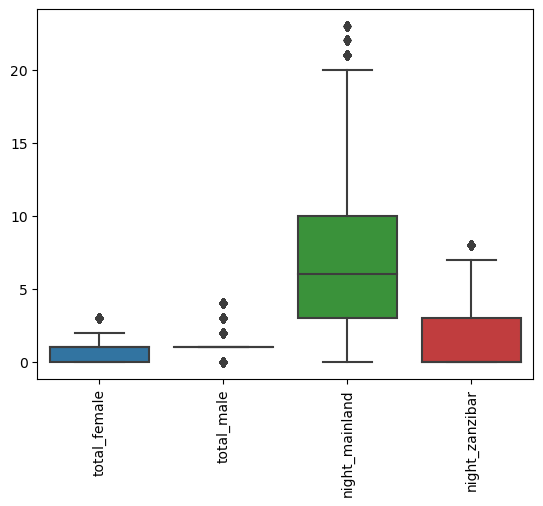

In [234]:
sns.boxplot(data=df)
plt.xticks(rotation=90);

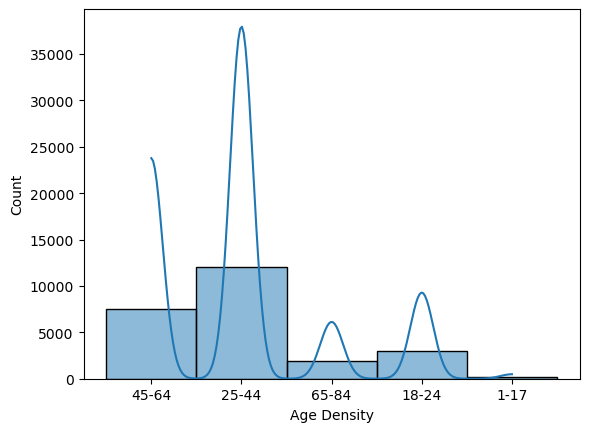

In [235]:
sns.histplot(df['age_group'], kde=True)
plt.xlabel('Age Density');

In [236]:
df.pivot_table('purpose', index='age_group', columns=['region', 'tour_arrangement'], fill_value=0,
              aggfunc='count')#.apply(lambda x: np.mean(x))

region                Africa                 Americas               \
tour_arrangement Independent Package Tour Independent Package Tour   
age_group                                                            
1-17                      21            2          10           16   
18-24                    469           44         212          148   
25-44                   3098          432         733          879   
45-64                   1018          275         486         1230   
65-84                     71           25         110          928   

region                  Asia                   Europe               \
tour_arrangement Independent Package Tour Independent Package Tour   
age_group                                                            
1-17                       3            1          35           63   
18-24                    169           59         815          816   
25-44                    758          330        2103         3092   
45-64                    297          220        1132         2397   
65-84                     22           58         179          372   

region               Oceania               
tour_arrangement Independent Package Tour  
age_group                                  
1-17                       0            1  
18-24                     50           66  
25-44                    120          259  
45-64                     82          304  
65-84                     22          144

In [237]:
df.pivot_table('purpose', index='region', columns='age_group',
              aggfunc='count').apply(lambda x: np.mean(x))

age_group
1-17       30.4
18-24     569.6
25-44    2360.8
45-64    1488.2
65-84     386.2
dtype: float64

In [165]:
np.sum(df['total_male'].values ** 2) / len(df['total_male'])

1.3456940222897669

In [166]:
df['total_male'].values ** 2

array([4., 1., 1., ..., 1., 0., 1.])

In [68]:
df.dominant_gender.value_counts() / len(df['dominant_gender'])

Male      0.378850
Equal     0.359965
Female    0.261185
Name: dominant_gender, dtype: float64

In [21]:
#train['age_category'] = train['age_group'].replace({'<18': 'young','18-24': 'young','25-44': 'middle_aged','45-64' : 'old','65+':'grands'})

#labels = ['three', 'five', 'week', 'ten', 'fortnight', 'month', 'year']
#bins = [0, 3, 5, 7, 10, 14, 21,  371]
#train['duration'] = pd.cut(train['total_nights'], bins=bins, labels=labels)

#labels = ['normal', 'minimal', 'nomini', 'big', 'grande']
#bins = [0, 1, 2, 3, 5, 93]
#df['travel_group_size'] = pd.cut(df['total_people'], bins=bins, labels=labels)

In [176]:
num_features = [col for col in df.select_dtypes(np.number)]
for f in num_features:
    #df["log_{}".format(f)] = (df[f] - df[f].min() + 1).transform(np.log)
    df.loc[:, f] = df[f].fillna(df[f].median())


cat_features = [] 
for x in df.select_dtypes('object', 'category'):
    df.loc[
        df['country'].value_counts()[df['country']].values < 20, "country"
    ] = "RARE"
    

    if x not in ('cost_category'):
        df.loc[:, x] = df[x].fillna("None").astype(str)
        cat_features.append(x)

        
com_features = []
combinations = list(itertools.combinations(com_features  , 2))
for f1, f2 in combinations:
    df.loc[:, f1 + "_" + f2 ] = df[f1].astype(str) + "_" + df[f2].astype(str) 
    cat_features.append(f1 + "_" + f2) 


In [238]:
len(num_features), len(cat_features)

(3, 18)

In [240]:
df.head()

,Tour_ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,...,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,first_trip_tz,cost_category,region,sub-region
0,tour_id1hffseyw,Italy,45-64,With Children,0.0,2.0,Visiting Friends and Relatives,Beach Tourism,"Friends, relatives",Package Tour,...,Yes,No,No,No,0.0,7.0,Yes,High Cost,Europe,Southern Europe
1,tour_idnacd7zag,United Kingdom,25-44,With Spouse,1.0,1.0,Leisure and Holidays,Wildlife Tourism,"Travel agent, tour operator",Package Tour,...,Yes,No,No,No,0.0,7.0,Yes,High Cost,Europe,Northern Europe
2,tour_id62vz7e71,United States Of America,65-84,With Spouse,1.0,1.0,Leisure and Holidays,Wildlife Tourism,"Travel agent, tour operator",Package Tour,...,Yes,Yes,Yes,No,6.0,6.0,Yes,Higher Cost,Americas,Northern America
3,tour_idrc76tzix,Rwanda,25-44,With Spouse and Children,3.0,1.0,Leisure and Holidays,Beach Tourism,"Radio, TV, Web",Independent,...,No,No,No,No,3.0,0.0,No,Lower Cost,Africa,Sub-Saharan Africa
4,tour_idn723m0n9,United States Of America,45-64,Alone,0.0,1.0,Leisure and Holidays,Wildlife Tourism,"Travel agent, tour operator",Package Tour,...,Yes,No,Yes,Yes,7.0,0.0,Yes,Higher Cost,Americas,Northern America


In [244]:
def chi_test(X, y):
    col_drop= []
    not_drop= []
    undecided=[]
    
    for col in X.columns:
        ct=pd.crosstab(y, X[col])
        chi2, p, dof, expected = chi2_contingency(ct)
        
        if p >= 0.05 or chi2 <= 2000:
            col_drop.append(col)
        elif p < 0.05 and  chi2 >= 5000:
            not_drop.append(col)
        else:
            undecided.append(col)
        
        print(f"------------------------\nColumn: {col}\nChi Test: {chi2}\nP_Value: {p}\nDOF: {dof}\n------------------------")
    print(f"\n\nSUMMARY: \nLittle or No correlation Columns: {col_drop}\n\nCorrelation not so strong columns: {undecided}\n\nStrong Correlation Columns: {not_drop}")

In [247]:
train = df[df.cost_category != -1].reset_index(drop=True)
test = df[df.cost_category == -1].reset_index(drop=True)
test.drop('cost_category', axis=1, inplace=True)

In [251]:
test.to_csv('../Datasets/new_test.csv')

In [252]:
X =train.drop([ 'cost_category', 'Tour_ID'], axis=1)
y = train['cost_category']

chi_test(X, y)

------------------------
Column: country
Chi Test: 9766.31671609103
P_Value: 0.0
DOF: 635
------------------------
------------------------
Column: age_group
Chi Test: 1803.1964576488913
P_Value: 0.0
DOF: 20
------------------------
------------------------
Column: travel_with
Chi Test: 4358.8256594511395
P_Value: 0.0
DOF: 20
------------------------
------------------------
Column: total_female
Chi Test: 3135.1341596685616
P_Value: 0.0
DOF: 15
------------------------
------------------------
Column: total_male
Chi Test: 804.2466108839939
P_Value: 1.775590677605355e-157
DOF: 20
------------------------
------------------------
Column: purpose
Chi Test: 6975.312873617305
P_Value: 0.0
DOF: 35
------------------------
------------------------
Column: main_activity
Chi Test: 3606.50524881434
P_Value: 0.0
DOF: 40
------------------------
------------------------
Column: info_source
Chi Test: 4166.3943611855575
P_Value: 0.0
DOF: 35
------------------------
------------------------
Column: t

In [253]:
#checking total number of unique values in each column. 
def check_unique(df):
    for col in df:
        print(col, len(df[col].unique()))

check_unique(X)

country 128
age_group 5
travel_with 6
total_female 4
total_male 5
purpose 8
main_activity 9
info_source 8
tour_arrangement 2
package_transport_int 2
package_accomodation 2
package_food 2
package_transport_tz 2
package_sightseeing 2
package_guided_tour 2
package_insurance 2
night_mainland 24
night_zanzibar 9
first_trip_tz 2
region 6
sub-region 15


In [254]:
#Checking and printing number of unique values in each categorical column
def cat_unique(df):
    for col in df.select_dtypes('object', 'category'):
        if df[col].nunique() > 20:
            print(f"\nColumn: {col}\nTotal number of Unique Values:  {df[col].nunique()}")
        else:
            print(f"\nColumn: {col}\nUnique Values: {df[col].nunique()}\n {df[col].unique()}")
            
cat_unique(X)


Column: country
Total number of Unique Values:  128

Column: age_group
Unique Values: 5
 ['45-64' '25-44' '65-84' '18-24' '1-17']

Column: travel_with
Unique Values: 5
 ['With Children' 'With Spouse' 'With Spouse and Children' 'Alone' nan
 'With Other Friends/Relatives']

Column: purpose
Unique Values: 8
 ['Visiting Friends and Relatives' 'Leisure and Holidays' 'Business'
 'Scientific and Academic' 'Meetings and Conference' 'Volunteering'
 'Other' 'Medical']

Column: main_activity
Unique Values: 9
 ['Beach Tourism' 'Wildlife Tourism' 'Cultural Tourism' 'Bird Tourism'
 'Hunting Tourism' 'Conference Tourism' 'Mountain Climbing' 'Business'
 'Diving and Sport Fishing']

Column: info_source
Unique Values: 8
 ['Friends, relatives' 'Travel agent, tour operator' 'Radio, TV, Web'
 'Newspaper, magazines, brochures' 'Others' 'Tanzania Mission Abroad'
 'Inflight magazines' 'Trade fair']

Column: tour_arrangement
Unique Values: 2
 ['Package Tour' 'Independent']

Column: package_transport_int
Uniqu

In [255]:
def showDetails(df):
    for col in df.select_dtypes('object', 'category') :
        if df[col].nunique() >= 20:
            print(f"{col} :\n {df[col].value_counts().reset_index(name= 'Total Count')[:10]}")
        else: 
            print('--------------------------------------------------------------------------')
            print(col)# + '& Cost Category')
            print(df[col].value_counts().reset_index(name="Total Count"))
            #tempDict = dict(df[col][df['cost_category'] == 'High Cost'].value_counts())
            #for i in tempDict.keys():
            #       tempDict[i] = ((tempDict[i]/len(df[df[col] == i]))*100).round(2)
            #print(tempDict)
            print('--------------------------------------------------------------------------')

showDetails(X)

country :
                       index  Total Count
0  United States Of America         2846
1            United Kingdom         2120
2                     Italy         1625
3                    France         1064
4                   Germany          969
5              South Africa          811
6                     Kenya          781
7                    Zambia          715
8                 Australia          704
9                    Canada          571
--------------------------------------------------------------------------
age_group
   index  Total Count
0  25-44         9047
1  45-64         5648
2  18-24         2222
3  65-84         1467
4   1-17          122
--------------------------------------------------------------------------
--------------------------------------------------------------------------
travel_with
                          index  Total Count
0                         Alone         7590
1                   With Spouse         4842
2  With Other Friends/Re

In [34]:
cat_features = [
    x for x in df.select_dtypes('object') if x not in ('Tour_ID', 'cost_category')
]

num_features = [n for n in df.select_dtypes(np.number)]

features = num_features + cat_features

In [256]:
col_drop= []
not_drop= []
undecided=[]

for col in train.columns:
    ct=pd.crosstab(train['cost_category'], train[col])
    chi2, p, dof, expected = chi2_contingency(ct)

    if p >= 0.05 or chi2 <= 2000:
        col_drop.append(col)
    elif p < 0.05 and  chi2 >= 3000:
        not_drop.append(col)
    else:
        undecided.append(col)

In [257]:
col_drop, undecided

(['Tour_ID', 'age_group', 'total_male', 'night_zanzibar'],
 ['package_insurance', 'first_trip_tz'])

In [258]:
drop = col_drop + undecided
X = train.drop(columns=['Tour_ID', 'cost_category'], axis=1)
#X = X.sample(frac=1)
y = train['cost_category']

In [259]:
mapping_age = {'0-17':1,
          '18-24':2 ,
          '25-44':3 ,
          '45-64':4,
          '65-100':5}

#X['age_group'] = X['age_group'].map(mapping_age).astype(np.float64)

le = LabelEncoder()
y = le.fit_transform(y)

In [260]:
cat_features = [
    x for x in X.select_dtypes('object') if x not in ('cost_category')
]

num_features = [n for n in X.select_dtypes(np.number)]

features = num_features + cat_features


num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy='median')),
    ("scaler", StandardScaler()),
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse_output=False))
])

pipe = ColumnTransformer([
    ("numerical", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)
])

tra = Pipeline([
    ("pipe", pipe),
    ("scaler", StandardScaler())

    #("svd", TruncatedSVD()))
])

X = tra.fit_transform(X)

In [261]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, stratify=y,
                                                   random_state=123)

In [262]:
X_train.shape

(12954, 204)

In [263]:
fold = StratifiedKFold(n_splits=10, shuffle=True)

def run(clf):
    scores = []
    for f, (train_idx, valid_idx) in enumerate (fold.split(X, y)):
        X_train, X_test = X[train_idx], X[valid_idx]
        y_train, y_test = y[train_idx], y[valid_idx]
        
        clf.fit(X_train, y_train)

        preds = clf.predict_proba(X_test)

        auc = roc_auc_score(y_test, preds, multi_class='ovr')
        scores.append(auc)

        print("Fold%2d: AUC = %.4f " %(f+1, auc))

    print("\nScore: %.4f (+/- %.4f) " % (np.mean(scores), np.std(scores)))

In [264]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB

nb = GaussianNB()
run(nb)

Fold 1: AUC = 0.6051 
Fold 2: AUC = 0.5929 
Fold 3: AUC = 0.6023 
Fold 4: AUC = 0.6014 
Fold 5: AUC = 0.5925 
Fold 6: AUC = 0.5929 
Fold 7: AUC = 0.5892 
Fold 8: AUC = 0.5938 
Fold 9: AUC = 0.6030 
Fold10: AUC = 0.6103 

Score: 0.5983 (+/- 0.0066) 


In [265]:
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)

print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

   High Cost       0.35      0.02      0.04      1103
 Higher Cost       0.35      0.01      0.02      1460
Highest Cost       0.02      0.95      0.05       108
    Low Cost       0.12      0.07      0.09       470
  Lower Cost       0.54      0.57      0.55       770
 Normal Cost       0.46      0.00      0.01      1641

    accuracy                           0.11      5552
   macro avg       0.31      0.27      0.13      5552
weighted avg       0.38      0.11      0.10      5552



In [266]:
lr = LogisticRegression(penalty='l2', C=0.1,
                        solver='lbfgs', multi_class='ovr',
                        max_iter=10000)
                        
run(lr)

Fold 1: AUC = 0.8167 
Fold 2: AUC = 0.8296 
Fold 3: AUC = 0.8234 
Fold 4: AUC = 0.8274 
Fold 5: AUC = 0.8276 
Fold 6: AUC = 0.8371 
Fold 7: AUC = 0.8124 
Fold 8: AUC = 0.8214 
Fold 9: AUC = 0.8320 
Fold10: AUC = 0.8386 

Score: 0.8266 (+/- 0.0080) 


In [267]:
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.5455691642651297

In [268]:
lr.score(X_train, y_train)

0.5694766095414544

In [269]:
y_pred = lr.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.46      0.30      0.36      1103
           1       0.60      0.77      0.68      1460
           2       0.25      0.02      0.03       108
           3       0.18      0.01      0.01       470
           4       0.56      0.62      0.59       770
           5       0.52      0.67      0.59      1641

    accuracy                           0.55      5552
   macro avg       0.43      0.40      0.38      5552
weighted avg       0.50      0.55      0.51      5552



In [270]:
from sklearn.metrics import precision_score, recall_score, f1_score
f1_score(y_test, y_pred, average='weighted')

0.5058606622591526

In [271]:
forest = RandomForestClassifier(n_estimators=300,
                                criterion='gini', 
                                random_state=123,
                                max_depth=6,
                                 n_jobs=-1)

run(forest)

Fold 1: AUC = 0.8360 
Fold 2: AUC = 0.8269 
Fold 3: AUC = 0.8367 
Fold 4: AUC = 0.8281 
Fold 5: AUC = 0.8158 
Fold 6: AUC = 0.8333 
Fold 7: AUC = 0.8247 
Fold 8: AUC = 0.8368 
Fold 9: AUC = 0.8361 
Fold10: AUC = 0.8283 

Score: 0.8303 (+/- 0.0065) 


In [272]:
forest.score(X_test, y_test)

0.5522334293948127

In [273]:
forest.score(X_train, y_train)

0.5521846533889146

In [274]:
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

In [275]:
predictions = forest.predict_proba(X_test)
roc_auc_score(y_test, predictions, multi_class='ovr')

0.8340313287716471

In [276]:
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

   High Cost       0.51      0.23      0.32      1103
 Higher Cost       0.57      0.84      0.68      1460
Highest Cost       0.00      0.00      0.00       108
    Low Cost       0.00      0.00      0.00       470
  Lower Cost       0.54      0.66      0.60       770
 Normal Cost       0.54      0.64      0.59      1641

    accuracy                           0.55      5552
   macro avg       0.36      0.40      0.36      5552
weighted avg       0.49      0.55      0.50      5552



<Axes: >

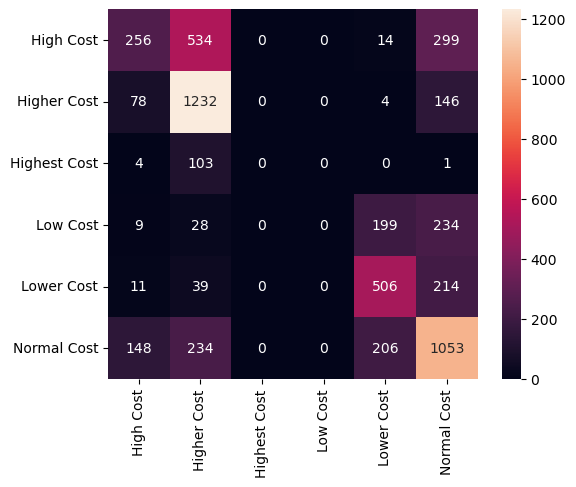

In [277]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, square=True, annot=True, fmt='d',
           xticklabels=le.classes_,
           yticklabels=le.classes_)

In [278]:
gr = SGDClassifier(loss='log_loss',
                   eta0=0.1,
                   learning_rate='optimal',
                  )

run(gr)

Fold 1: AUC = 0.8005 
Fold 2: AUC = 0.8018 
Fold 3: AUC = 0.7872 
Fold 4: AUC = 0.8060 
Fold 5: AUC = 0.7906 
Fold 6: AUC = 0.7965 
Fold 7: AUC = 0.7852 
Fold 8: AUC = 0.7872 
Fold 9: AUC = 0.7893 
Fold10: AUC = 0.7989 

Score: 0.7943 (+/- 0.0069) 


In [279]:
gr.fit(X_train, y_train)
predss = gr.predict_proba(X_test)
roc_auc_score(y_test, predss, multi_class='ovr')

0.7984405641718383

In [280]:
gr.score(X_test, y_test)

0.524135446685879

In [281]:
gr.score(X_train, y_train)

0.5304925119654161

In [282]:
print(classification_report(y_test, gr.predict(X_test), target_names=le.classes_))

              precision    recall  f1-score   support

   High Cost       0.46      0.29      0.36      1103
 Higher Cost       0.60      0.76      0.67      1460
Highest Cost       0.10      0.02      0.03       108
    Low Cost       0.24      0.12      0.16       470
  Lower Cost       0.60      0.44      0.51       770
 Normal Cost       0.50      0.66      0.57      1641

    accuracy                           0.52      5552
   macro avg       0.42      0.38      0.38      5552
weighted avg       0.50      0.52      0.50      5552



In [283]:
lsv = LinearSVC(penalty='l2', loss='squared_hinge', C=0.1, class_weight='balanced',
          multi_class='ovr', random_state=123)

lsv.fit(X_train, y_train)
y_pred = lsv.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

   High Cost       0.46      0.32      0.38      1103
 Higher Cost       0.61      0.70      0.65      1460
Highest Cost       0.10      0.29      0.15       108
    Low Cost       0.20      0.07      0.11       470
  Lower Cost       0.52      0.65      0.58       770
 Normal Cost       0.54      0.56      0.55      1641

    accuracy                           0.51      5552
   macro avg       0.41      0.43      0.40      5552
weighted avg       0.50      0.51      0.50      5552



In [289]:
from catboost import CatBoostClassifier

cat = CatBoostClassifier(iterations=600,
                         learning_rate=0.1,
                         max_depth=4,
                         logging_level='Silent',
                         random_state=123)
run(cat)

Fold 1: AUC = 0.8458 
Fold 2: AUC = 0.8474 
Fold 3: AUC = 0.8428 
Fold 4: AUC = 0.8509 
Fold 5: AUC = 0.8455 
Fold 6: AUC = 0.8596 
Fold 7: AUC = 0.8464 
Fold 8: AUC = 0.8554 
Fold 9: AUC = 0.8516 
Fold10: AUC = 0.8435 

Score: 0.8489 (+/- 0.0051) 


In [290]:
cat.fit(X_train, y_train)

y_pred = cat.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

   High Cost       0.53      0.35      0.42      1103
 Higher Cost       0.64      0.77      0.70      1460
Highest Cost       0.38      0.05      0.08       108
    Low Cost       0.40      0.02      0.03       470
  Lower Cost       0.59      0.66      0.62       770
 Normal Cost       0.54      0.71      0.61      1641

    accuracy                           0.58      5552
   macro avg       0.51      0.43      0.41      5552
weighted avg       0.56      0.58      0.54      5552



In [291]:
preds = cat.predict_proba(X_test)
print(roc_auc_score(y_test, preds, multi_class='ovr'))

0.8525554583394831


<Axes: >

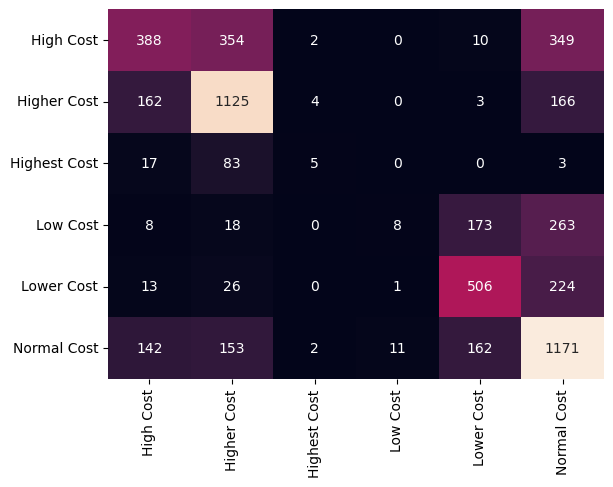

In [292]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cbar=False,
           xticklabels=le.classes_,
           yticklabels=le.classes_)

In [293]:
xgb  = XGBClassifier(n_estimators=200,
                    max_depth=8, n_jobs=-1)

run(xgb)

Fold 1: AUC = 0.8289 
Fold 2: AUC = 0.8335 
Fold 3: AUC = 0.8263 
Fold 4: AUC = 0.8392 
Fold 5: AUC = 0.8296 
Fold 6: AUC = 0.8267 
Fold 7: AUC = 0.8273 
Fold 8: AUC = 0.8391 
Fold 9: AUC = 0.8222 
Fold10: AUC = 0.8389 

Score: 0.8312 (+/- 0.0058) 


In [294]:
#xgb.fit(X_train, y_train)
predss = xgb.predict_proba(X_test)
roc_auc_score(y_test, predss, multi_class='ovr')

0.9709872062360043

In [295]:
xgb.score(X_test, y_test)

0.8296109510086456

In [296]:
xgb.score(X_train, y_train)

0.825845298749421

In [297]:
print(classification_report(y_test, xgb.predict(X_test), target_names=le.classes_))

              precision    recall  f1-score   support

   High Cost       0.85      0.73      0.79      1103
 Higher Cost       0.84      0.93      0.88      1460
Highest Cost       0.91      0.77      0.83       108
    Low Cost       0.89      0.61      0.73       470
  Lower Cost       0.79      0.88      0.83       770
 Normal Cost       0.82      0.85      0.83      1641

    accuracy                           0.83      5552
   macro avg       0.85      0.80      0.82      5552
weighted avg       0.83      0.83      0.83      5552



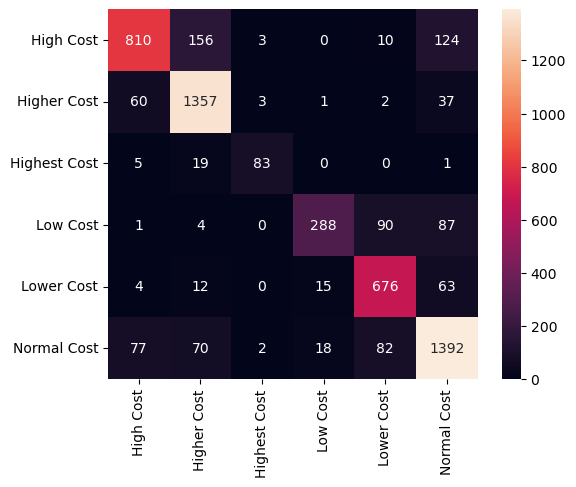

In [298]:
cm = confusion_matrix(y_test, xgb.predict(X_test))
sns.heatmap(cm, square=True, annot=True, fmt='d',
           xticklabels=le.classes_,
           yticklabels=le.classes_);

In [314]:
X = train.drop(columns=['Tour_ID', 'cost_category'], axis=1)
y = train['cost_category']

In [315]:
categorical = []
for col in X.select_dtypes(['object', 'category']):
    X.loc[:, col] = X[col].fillna("None").astype(str)
    categorical.append(col)

In [316]:
for col in X.select_dtypes(['object', 'category']):
    X[col] = X[col].astype('category')

In [317]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=142)

In [324]:
cat = CatBoostClassifier(iterations=300,
                         learning_rate=0.1, 
                         max_depth=5, logging_level='Silent',
                         cat_features=categorical,
                         random_state=142)

In [319]:
cat.fit(X_train, y_train)

In [320]:
y_pred = cat.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   High Cost       0.53      0.37      0.44       697
 Higher Cost       0.65      0.79      0.71       961
Highest Cost       0.00      0.00      0.00        78
    Low Cost       0.12      0.00      0.01       323
  Lower Cost       0.61      0.62      0.61       550
 Normal Cost       0.53      0.71      0.61      1093

    accuracy                           0.58      3702
   macro avg       0.41      0.42      0.40      3702
weighted avg       0.53      0.58      0.54      3702



In [325]:
scores = cross_val_score(cat,
                         X_train, y_train,
                         cv=10,
                         scoring='roc_auc_ovr')


print("ROC AUC: %.3f (+/- %.3f)" % (scores.mean(), 
                                    scores.std()))

ROC AUC: 0.844 (+/- 0.007)


In [370]:
cat.feature_importances_

array(None, dtype=object)

In [118]:
train.to_csv('train.csv')

In [119]:
from sklearn.metrics import make_scorer
scorer = make_scorer(roc_auc_score, 
                     greater_is_better=True, needs_proba=True)

gs = GridSearchCV(estimator=cat,
                 param_grid=[{
                     "iterations":[150, 200, 300],
                     "max_depth":[1, 2, 3, 4, 5, 6, 7],
                     "learning_rate": [0.01, 0.1, 1],
                     "logging_level": ['Silent'],
                 }],
                 cv=2, scoring='roc_auc_ovr', n_jobs=-1, verbose=1)

gs.fit(X_train, y_train)

Fitting 2 folds for each of 63 candidates, totalling 126 fits


GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostClassifier object at 0x00000298DB7ABA60>,
             n_jobs=-1,
             param_grid=[{'iterations': [150, 200, 300],
                          'learning_rate': [0.01, 0.1, 1],
                          'logging_level': ['Silent'],
                          'max_depth': [1, 2, 3, 4, 5, 6, 7]}],
             scoring='roc_auc_ovr', verbose=1)

In [120]:
scores = cross_val_score(gs, X_train, y_train,
                       cv=5, scoring='roc_auc_ovr')

print("AUC Score: %.3f (+/- %.3f)" % (np.mean(scores),
                                     np.std(scores)))

Fitting 2 folds for each of 63 candidates, totalling 126 fits
Fitting 2 folds for each of 63 candidates, totalling 126 fits
Fitting 2 folds for each of 63 candidates, totalling 126 fits
Fitting 2 folds for each of 63 candidates, totalling 126 fits
Fitting 2 folds for each of 63 candidates, totalling 126 fits
AUC Score: 0.849 (+/- 0.008)


In [121]:
gs.best_params_

{'iterations': 200,
 'learning_rate': 0.1,
 'logging_level': 'Silent',
 'max_depth': 5}

In [122]:
gs.best_score_

0.8455432219953658

In [ ]:
def model_selection(classifier): 
    gs = GridSearchCV(estimator=classifier,
                 param_grid=[{
                     "n_estimators":[ 200, 300, None],
                     "max_depth":[1, 2, 3,
                                  4, 7, None],
                     "criterion":['gini', 'entropy', 'log_loss']
                 }],
                 cv=2, scoring='roc_auc', n_jobs=-1, verbose=1)

    gs.fit(X_train, y_train)
    
    scores = cross_val_score(gs, X_train, y_train,
                       cv=5, scoring='roc_auc')

    print('AUC Score: %.3f (+/- %.3f' % (np.mean(scores),
                                         np.std(scores)))

In [ ]:
model_selection(forest)

In [ ]:
model_selection(xgb)

In [ ]:
importances = forest.feature_importances_
imp = np.argsort(importances)
imp

In [ ]:
from sklearn.feature_extraction.text import HashingVectorizer
for x in df.select_dtypes('object'):
    if x not in ['Tour_ID']:
        if df[x].nunique() >= 30:
            vect = HashingVectorizer(n_features = 2**8,
                                     encoding='iso-8859-1',
                                     decode_error="ignore",
                                     lowercase=False,
                                     binary=True)

            xx = vect.fit_transform(df[x])
            xx = pd.DataFrame(xx.toarray()).assign(x = df[x].values)
            display(xx)

In [ ]:
train['total_male'].values != train['total_female'].values

In [ ]:
g = []
for col in train.columns:
    if (train['total_male'].values > train['total_female'].values) == True:
        g.append('M')
    else:
        g.append('F')

In [ ]:
train['total_people']=train['total_male'] + train['total_female']
train['total_nights']=train['night_zanzibar']+train['night_mainland']
train['average_stay']= (train['total_people'] / train['total_nights']).round(2)
train['age_category'] = train['age_group'].replace({'0-18': 'young',
                                                   '18-24': 'young',
                                                   '25-44': 'middle_aged',
                                                   '45-64' : 'old',
                                                   '65-100':'grands'})

labels = ['three', 'five', 'week', 'ten', 'fortnight', 'month', 'year']
bins = [0, 3, 5, 7, 10, 14, 21,  371]
train['stay_length'] = pd.cut(train['total_nights'], bins=bins, labels=labels)

labels = ['normal', 'minimal', 'nomini', 'big', 'grande']
bins = [0, 1, 2, 3, 5, 93]
train['travel_group'] = pd.cut(train['total_people'], bins=bins, labels=labels)

#train['']

In [237]:
def check_outliers(data, factor:int, strategy='median', inplace=True):
    for col in data.select_dtypes(include=['int', 'float']).columns:
        lower_qtl = data[col].quantile(0.25)
        upper_qtl=data[col].quantile(0.75)
        iqr=(upper_qtl-lower_qtl)
        u_bound= upper_qtl + factor * iqr
        l_bound= lower_qtl - factor * iqr
        
        outliers=[] 
        for x in data[col]:
            if ((x > u_bound) or (x  < l_bound)):
                outliers.append(x)
                
        if strategy == 'mean':
            replacement = data[col].mean()
        elif strategy == 'median':
            replacement = data[col].median()
        elif strategy == 'mode':
            replacement = data[col].mode()[0]
            
        for idx in outliers:
            data.loc[idx,col]=replacement
        
        print(f"\n\nColumn: {col}\nLower_Bound: {l_bound}\nUpper_Bound: {u_bound}\nOutliers: {outliers}")
    
    print(f"\n\n\nOutliers Succesfully replaced with {strategy}.")

In [239]:
%%time
check_outliers(df,factor=3, strategy='median', inplace=True)



Column: total_female
Lower_Bound: -3.0
Upper_Bound: 4.0
Outliers: []


Column: total_male
Lower_Bound: 1.0
Upper_Bound: 1.0
Outliers: [2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 4.0, 2.0, 0.0, 0.0, 3.0, 0.0, 3.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 2.0, 3.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 0.0, 0.0, 2.0, 0.0, 2.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 3.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 2.0, 0.0, 2.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 2.0, 0.0, 3.0, 2.0, 0.0, 2.0, 2.0, 0.0, 0.0, 3.0, 0.0, 0.0, 2.0, 0.0, 2.0, 0.0, 2.0, 2.0, 2.0, 2.0, 3.0, 2.0, 0.0, 3.0, 0.0, 3.0, 2.0, 0.0, 0.0, 0.0, 2.0, 0.0, 2.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 4.0, 0.0, 0.0, 2.0, 0.0, 0.0, 4.0, 0.0



Column: average_stay_per_person
Lower_Bound: -0.43000000000000005
Upper_Bound: 0.9000000000000001
Outliers: [1.33, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.4, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.33, 1.0, 1.0, 1.5, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.25, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.5, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 4.0, 1.0, 1.0, 1.33, 1.0, 1.0, 1.5, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.5, 2.0, 1.0, 1.0, 1.33, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.33, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.33, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.5, 1.0, 2.0, 1.0, 1.0, 1.0, 1.5, 1.0, 1.0, 1.33, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.5, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.5, 1.0, 1.2, 1.67, 1.0, 1.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.33, 1.67

In [ ]:
mapping = {'0-17':1,
          '18-24':2 ,
          '25-44':3 ,
          '45-64':4,
          '65-100':5}

df['age_group'] = df['age_group'].map(mapping).astype(np.float64)
df.head()

In [367]:
obs_vars = df.groupby('main_activity').mean().var()[0]
print("Observed mean: ", df.groupby('main_activity').mean().values.ravel())

Observed mean:  [0.91755889 0.97412562 3.68754461 2.82566024 0.69101124 0.87078652
 6.9494382  0.8988764  0.82972973 1.08918919 3.37297297 2.81621622
 0.67101106 0.89060032 9.58372828 0.92377567 0.77772047 0.80195977
 6.21402785 1.37854564 0.675      0.95       8.175      0.65
 0.50425056 0.81610738 5.8917226  0.26577181 0.41265475 0.8431912
 5.18707015 0.25997249 0.89782805 0.95628959 7.75855204 1.38515837]


In [368]:
print("Observed Variance: ", obs_vars)

Observed Variance:  0.02888932750918336


In [369]:
def perm_test(df):
    df = train.copy()
    df['total_people'] = np.random.permutation(df['total_male'].values)
    
    return df.groupby('main_activity').mean().var()[0]

perm_variance = [perm_test(df) for _ in range(3000)]
print('Pr(Prob)', np.mean([var > obs_vars for var in perm_variance]))

Pr(Prob) 1.0


In [ ]:
df.to_csv('new.csv')